In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Load datasets
df = pd.read_csv('C:/Users/q/Desktop/James/Schulich/Data Science II/assignment2/Customer_Data.csv')

In [2]:
print(df.shape)
df.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
# 1. 检查 MINIMUM_PAYMENTS 缺失样本的其他行为
missing_minpay = df[df["MINIMUM_PAYMENTS"].isna()]
missing_summary = missing_minpay[["PURCHASES", "CASH_ADVANCE", "PAYMENTS"]].describe()

# 2. 检查这些样本是否全为 0
all_zero_ratio = ((missing_minpay[["PURCHASES","CASH_ADVANCE","PAYMENTS"]] == 0).all(axis=1)).mean()
print("在 MINIMUM_PAYMENTS 缺失的样本中，所有消费/还款均为0的比例为:", all_zero_ratio)

在 MINIMUM_PAYMENTS 缺失的样本中，所有消费/还款均为0的比例为: 0.0


In [5]:
# 备份原始数据（便于回溯）
df_raw = df.copy()

# 需要填补的列
cols_to_impute = ["MINIMUM_PAYMENTS", "CREDIT_LIMIT"]

# 记录填补前缺失数
print("填补前 NA 计数：")
print(df[cols_to_impute].isna().sum())

# 中位数填补（稳健）
medians = df[cols_to_impute].median(numeric_only=True)
df[cols_to_impute] = df[cols_to_impute].fillna(medians)

# 记录填补后缺失数
print("\n填补后 NA 计数：")
print(df[cols_to_impute].isna().sum())

填补前 NA 计数：
MINIMUM_PAYMENTS    313
CREDIT_LIMIT          1
dtype: int64

填补后 NA 计数：
MINIMUM_PAYMENTS    0
CREDIT_LIMIT        0
dtype: int64


In [6]:
# 检查所有数值列的偏度
numeric_cols = df.select_dtypes(include=[float, int]).columns
skew_vals = df[numeric_cols].skew().sort_values(ascending=False)
print(skew_vals)


MINIMUM_PAYMENTS                    13.852446
ONEOFF_PURCHASES                    10.045083
PURCHASES                            8.144269
INSTALLMENTS_PURCHASES               7.299120
PAYMENTS                             5.907620
CASH_ADVANCE_TRX                     5.721298
CASH_ADVANCE                         5.166609
PURCHASES_TRX                        4.630655
BALANCE                              2.393386
PRC_FULL_PAYMENT                     1.942820
CASH_ADVANCE_FREQUENCY               1.828686
ONEOFF_PURCHASES_FREQUENCY           1.535613
CREDIT_LIMIT                         1.522636
PURCHASES_INSTALLMENTS_FREQUENCY     0.509201
PURCHASES_FREQUENCY                  0.060164
BALANCE_FREQUENCY                   -2.023266
TENURE                              -2.943017
dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler

# 确保 df 已填补缺失值
amount_cols = [
    "BALANCE", "PURCHASES", "ONEOFF_PURCHASES", "INSTALLMENTS_PURCHASES",
    "CASH_ADVANCE", "PAYMENTS", "CREDIT_LIMIT", "MINIMUM_PAYMENTS"
]
freq_cols = [
    "BALANCE_FREQUENCY", "PURCHASES_FREQUENCY", "ONEOFF_PURCHASES_FREQUENCY",
    "PURCHASES_INSTALLMENTS_FREQUENCY", "CASH_ADVANCE_FREQUENCY", "PRC_FULL_PAYMENT"
]
count_cols = ["CASH_ADVANCE_TRX", "PURCHASES_TRX"]
tenure_col = ["TENURE"]

feature_cols = amount_cols + freq_cols + count_cols + tenure_col

# log1p变换
df_t = df.copy()
for c in amount_cols + count_cols:
    df_t[c] = np.log1p(df_t[c].astype(float))

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_t[feature_cols])
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df["CUST_ID"])

print("X_scaled_df 维度：", X_scaled_df.shape)


X_scaled_df 维度： (8950, 17)


前10个主成分累计解释方差比例：
[0.339 0.558 0.652 0.726 0.792 0.842 0.883 0.915 0.941 0.959]


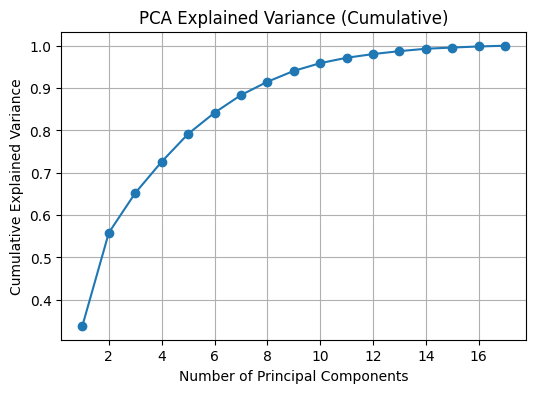

In [ ]:
from sklearn.decomposition import PCA


# 拟合 PCA
pca = PCA().fit(X_scaled_df)

# 输出累计解释方差
cum_var = np.cumsum(pca.explained_variance_ratio_)
print("前10个主成分累计解释方差比例：")
print(np.round(cum_var[:10], 3))

# 绘制 Elbow-like 图查看拐点
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance (Cumulative)")
plt.grid(True)
plt.show()


Ks: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Inertia: [113331.6, 95644.7, 86547.0, 77932.5, 71656.4, 67948.5, 64555.2, 61496.2, 58828.2]
Silhouette: [0.2515, 0.2244, 0.2166, 0.2181, 0.2172, 0.2197, 0.2098, 0.1806, 0.1817]


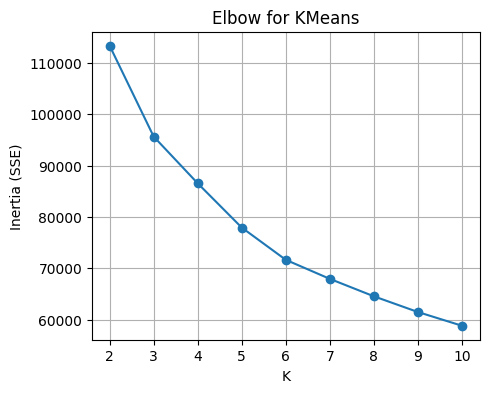

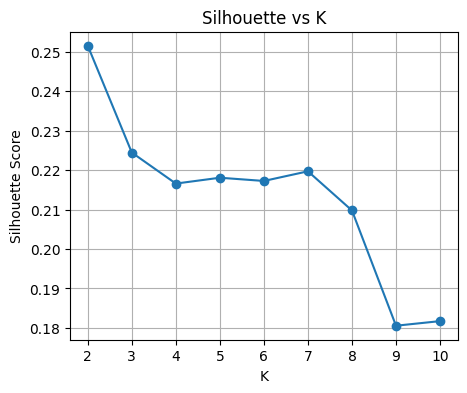

Silhouette 最高的 K = 2


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


X = X_scaled_df.values

ks = range(2, 11)  # 你也可加大到 2..12/15 观察是否稳定
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

print("Ks:", list(ks))
print("Inertia:", [round(v, 1) for v in inertias])
print("Silhouette:", [round(v, 4) for v in sil_scores])

# 画两张简单图（便于你判断拐点&峰值）
plt.figure(figsize=(5,4))
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("K")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow for KMeans")
plt.grid(True)
plt.show()

plt.figure(figsize=(5,4))
plt.plot(list(ks), sil_scores, marker="o")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs K")
plt.grid(True)
plt.show()


[KMeans] K=3, silhouette=0.2244

每簇样本量：
cluster_km
0    2893
1    3186
2    2871
Name: count, dtype: int64

每簇Top5区分特征（基于|Z中心|）：
Cluster 0: {'BALANCE': -1.03, 'CASH_ADVANCE': -0.81, 'MINIMUM_PAYMENTS': -0.78, 'CASH_ADVANCE_TRX': -0.74, 'BALANCE_FREQUENCY': -0.67}
Cluster 1: {'PURCHASES_TRX': 0.95, 'PURCHASES_FREQUENCY': 0.87, 'ONEOFF_PURCHASES_FREQUENCY': 0.85, 'PURCHASES': 0.81, 'ONEOFF_PURCHASES': 0.8}
Cluster 2: {'PURCHASES': -1.11, 'PURCHASES_TRX': -1.07, 'PURCHASES_FREQUENCY': -1.04, 'CASH_ADVANCE': 1.0, 'INSTALLMENTS_PURCHASES': -0.94}

—— 原始中位数（前8列预览）——
            BALANCE  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
cluster_km                                                                 
0             56.72     307.40              0.00                  158.00   
1           1273.82    1448.66            765.82                  490.76   
2           1615.97       0.00              0.00                    0.00   

            CASH_ADVANCE  PAYMENTS  CREDIT_LIMIT  MI

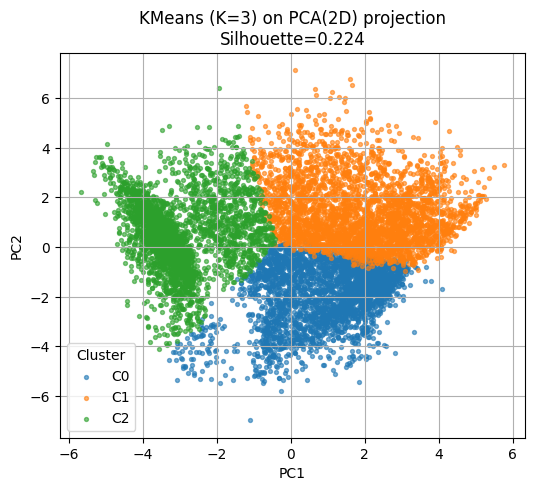

In [15]:
X = X_scaled_df.values
feature_cols = X_scaled_df.columns.tolist()

# 1) 训练最终模型
K = 3
km = KMeans(n_clusters=K, n_init=30, random_state=42)
labels = km.fit_predict(X)

# 2) 评估一下（便于记录到作业）
sil = silhouette_score(X, labels)
print(f"[KMeans] K={K}, silhouette={sil:.4f}")

# 3) 贴回原始数据，方便画像（用未 log 的 df 更好解释）
df_km = df.copy()
df_km["cluster_km"] = labels
print("\n每簇样本量：")
print(df_km["cluster_km"].value_counts().sort_index())

# 4) 标准化空间的中心（看相对高低）
centers_z = pd.DataFrame(km.cluster_centers_, columns=feature_cols)
print("\n每簇Top5区分特征（基于|Z中心|）：")
for cid in range(K):
    top5 = (
        centers_z.iloc[cid].abs()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
    )
    signed = centers_z.loc[cid, top5].round(2).to_dict()
    print(f"Cluster {cid}: {signed}")

# 5) 原始尺度上的簇画像（中位数 + 相对提升/下降）
overall_median = df_km[feature_cols].median()
cluster_median = df_km.groupby("cluster_km")[feature_cols].median().round(2)
lift = (cluster_median / overall_median - 1).replace([np.inf, -np.inf], np.nan).round(2)

print("\n—— 原始中位数（前8列预览）——")
print(cluster_median.iloc[:, :8])

print("\n—— 相对整体中位数的提升率 lift（前8列预览）——")
print(lift.iloc[:, :8])

# 6) 快速提炼：每簇最显著 ↑ / ↓ 的 Top5 特征（基于 lift）
def top_changes(row, topn=5):
    inc = row.sort_values(ascending=False).head(topn).index.tolist()
    dec = row.sort_values(ascending=True).head(topn).index.tolist()
    return inc, dec

print("\n每簇显著 ↑/↓ 的Top5（基于lift）：")
for cid in range(K):
    inc, dec = top_changes(lift.loc[cid])
    print(f"Cluster {cid} ↑: {inc}")
    print(f"Cluster {cid} ↓: {dec}")

# 7) 可视化（PCA 2D 投影上的簇分布，仅用于展示）
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)

plt.figure(figsize=(6,5))
for c in range(K):
    idx = (labels == c)
    plt.scatter(X_pca2[idx,0], X_pca2[idx,1], s=8, alpha=0.6, label=f"C{c}")
plt.legend(title="Cluster")
plt.title(f"KMeans (K={K}) on PCA(2D) projection\nSilhouette={sil:.3f}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True)
plt.show()

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

agg = AgglomerativeClustering(n_clusters=3, linkage="ward", metric="euclidean")
labels_agg = agg.fit_predict(X)

sil_agg = silhouette_score(X, labels_agg)
from sklearn.metrics import silhouette_samples
ari = adjusted_rand_score(labels, labels_agg)

print(f"[Agglomerative-Ward] silhouette={sil_agg:.4f}, ARI_vs_KMeans={ari:.3f}")
print("Sizes:", pd.Series(labels_agg).value_counts().sort_index().to_dict())

[Agglomerative-Ward] silhouette=0.1745, ARI_vs_KMeans=0.529
Sizes: {0: 3423, 1: 2255, 2: 3272}


In [20]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5).fit(X)
dists, _ = nn.kneighbors(X)
k_dists = np.sort(dists[:, -1])

# 经验：拐点附近作为起点；这里用分位数生成候选
q = np.quantile(k_dists, [0.90, 0.92, 0.95, 0.97, 0.99])
print("k-dist quantiles (k=5):", np.round(q, 3))


k-dist quantiles (k=5): [1.834 1.939 2.127 2.318 2.75 ]


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
 
eps_grid = list(q)  # 直接用上面的分位数，也可自行加点比如 +0.02 步进
results = []

for eps in eps_grid:
    db = DBSCAN(eps=float(eps), min_samples=5).fit(X)
    lbl = db.labels_
    n_noise = int(np.sum(lbl == -1))
    n_clu = len(set(lbl)) - (1 if -1 in lbl else 0)
    sil = np.nan
    if n_clu >= 2:
        mask = (lbl != -1)
        sil = silhouette_score(X[mask], lbl[mask])
    results.append({"eps": float(eps), "clusters": n_clu, "noise": n_noise, "sil_nonnoise": None if np.isnan(sil) else round(sil,4)})

import pandas as pd
pd.DataFrame(results)


,eps,clusters,noise,sil_nonnoise
0,1.833569,12,487,-0.0572
1,1.938565,8,354,-0.0611
2,2.126551,2,203,0.2028
3,2.317638,1,102,NaN
4,2.750476,1,29,NaN
